# Steps involved in making recommendation system:
* Importing neccessary libraries
* Data collection
* Data importing
* Data cleaning and preprocessing
* Data analysis and visualization
* Machine learning model implementation
    1. Content-based filtering
    2. Collaborative filtering
* Model evaluation
* Hyperparameter tuning and model evaluation again

Dataset used:
For this project i am using the movielens small dataset: https://grouplens.org/datasets/movielens/latest/


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# this is required to make the plot appear inside the notebook


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import mean_squared_error

# from sklearn.model_selection import train_test_split
from wordcloud import WordCloud


# importing surprise library
from surprise.model_selection import train_test_split

from surprise import SVD, Reader, KNNBasic
from surprise import Dataset, dump
from surprise import accuracy
import pickle

import warnings; warnings.simplefilter('ignore')

Description of the tmdb dataset
credits dataset:
* movie_id - A unique identifier for each movie.
* cast - The name of lead and supporting actors.
* crew - The name of Director, Editor, Composer, Writer etc.

movies dataset:
* budget - The budget in which the movie was made.
* genre - The genre of the movie, Action, Comedy ,Thriller etc.
* homepage - A link to the homepage of the movie.
id - This is infact the movie_id as in the first dataset.
* keywords - The keywords or tags related to the movie.
* original_language - The language in which the movie was made.
* original_title - The title of the movie before translation or adaptation.
* overview - A brief description of the movie.
* popularity - A numeric quantity specifying the movie popularity.
* production_companies - The production house of the movie.
* production_countries - The country in which it was produced.
* release_date - The date on which it was released.
* revenue - The worldwide revenue generated by the movie.
* runtime - The running time of the movie in minutes.
* status - "Released" or "Rumored".
* tagline - Movie's tagline.
* title - Title of the movie.
* vote_average - average ratings the movie recieved.
* vote_count - the count of votes recieved.

In [4]:
# df1=pd.read_csv('TMDB Dataset/tmdb_5000_movies.csv')
# df2=pd.read_csv('TMDB Dataset/tmdb_5000_credits.csv')

In [5]:
# df1.head()

In [6]:
# df2.head()

# movie lens dataset

In [7]:
linksdf=pd.read_csv('Movielens dataset/links.csv')
tagsdf=pd.read_csv('Movielens dataset/tags.csv')
moviesdf=pd.read_csv('Movielens dataset/movies.csv')
ratingsdf=pd.read_csv('Movielens dataset/ratings.csv')

In [8]:
linksdf.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [9]:
tagsdf.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [10]:
moviesdf.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
ratingsdf.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# Merging the dataset and analysing as one dataset

In [12]:
movies_rating_df = pd.merge(moviesdf, ratingsdf, on='movieId')

In [13]:
movies_rating_df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [14]:
movies_rating_df.shape

(100836, 6)

In [15]:
movies_rating_df.columns


Index(['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp'], dtype='object')

In [16]:
movies_rating_df.isna().sum()

movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64

In [17]:
# Analysing the insights of the data
movies_rating_df.describe()

,movieId,userId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,19435.295718,326.127564,3.501557,1.205946e+09
std,35530.987199,182.618491,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,1199.000000,177.000000,3.000000,1.019124e+09
50%,2991.000000,325.000000,3.500000,1.186087e+09
75%,8122.000000,477.000000,4.000000,1.435994e+09
max,193609.000000,610.000000,5.000000,1.537799e+09


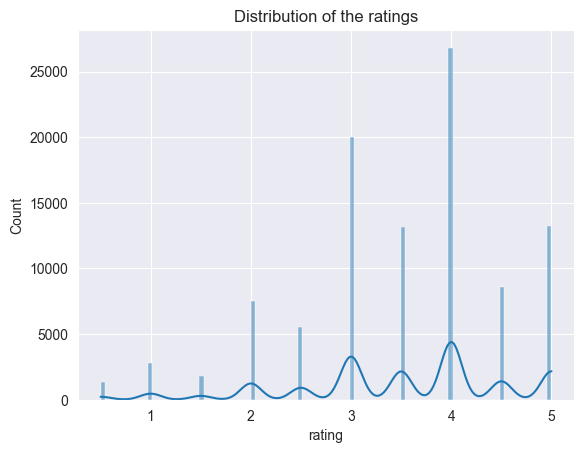

In [18]:
# Data distribution of ratings
sns.histplot(movies_rating_df['rating'], kde=True)
plt.title('Distribution of the ratings')
plt.show()

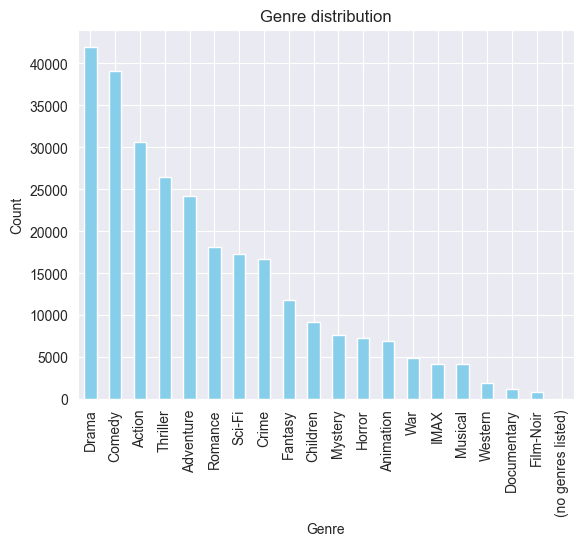

In [19]:
# Genre Analysis
genre_counts=movies_rating_df['genres'].str.split('|', expand=True).stack().value_counts()
genre_counts.plot(kind='bar', color='skyblue')
plt.title("Genre distribution")
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

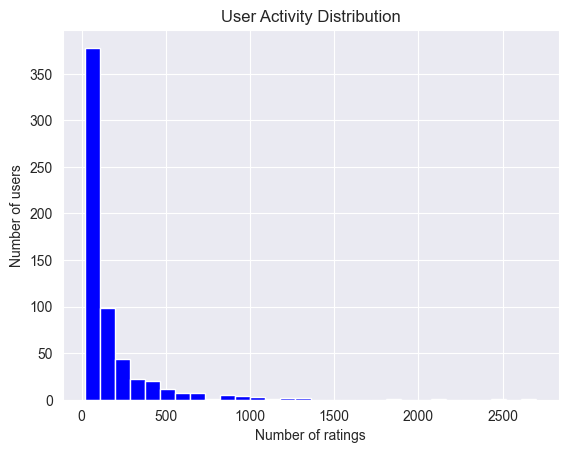

In [20]:
# user activity analysis
# visualising the number of ratings per user
user_activity=movies_rating_df['userId'].value_counts()
user_activity.plot(kind='hist', bins=30, color='blue')
plt.title('User Activity Distribution')
plt.xlabel('Number of ratings')
plt.ylabel('Number of users')
plt.show()

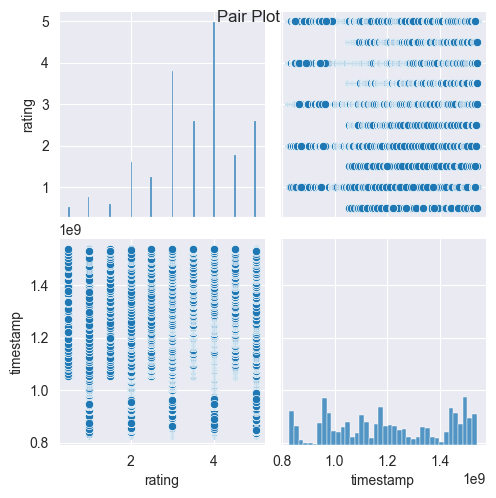

In [21]:
# Ploting pair plot to visualise the realtionship between ratings and timestamp
sns.pairplot(movies_rating_df[['rating', 'timestamp']])
plt.suptitle('Pair Plot')
plt.show()

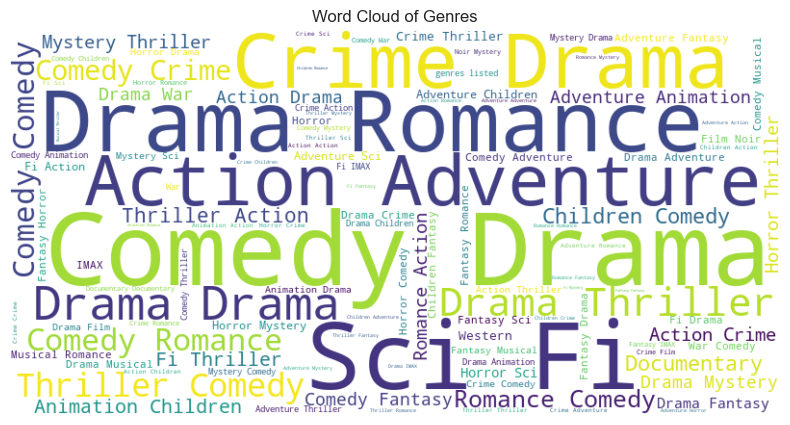

In [22]:
# Plotting a word cloud to find the most common genre in the dataset
genres_text = ' '.join(moviesdf['genres'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(genres_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Genres')
plt.show()

In [23]:
genres_text

'Adventure|Animation|Children|Comedy|Fantasy Adventure|Children|Fantasy Comedy|Romance Comedy|Drama|Romance Comedy Action|Crime|Thriller Comedy|Romance Adventure|Children Action Action|Adventure|Thriller Comedy|Drama|Romance Comedy|Horror Adventure|Animation|Children Drama Action|Adventure|Romance Crime|Drama Drama|Romance Comedy Comedy Action|Comedy|Crime|Drama|Thriller Comedy|Crime|Thriller Crime|Drama|Horror|Mystery|Thriller Action|Crime|Thriller Drama|Sci-Fi Drama|Romance Drama Children|Drama Drama|Romance Adventure|Drama|Fantasy|Mystery|Sci-Fi Crime|Drama Drama Mystery|Sci-Fi|Thriller Children|Drama Crime|Drama Children|Comedy Comedy|Romance Drama Drama|War Action|Crime|Drama Drama Action|Adventure|Fantasy Comedy|Drama|Thriller Drama|Romance Mystery|Thriller Animation|Children|Drama|Musical|Romance Drama|Romance Crime|Mystery|Thriller Comedy|Drama|Romance Adventure|Drama Children|Comedy Drama Drama Comedy|Drama|Romance Adventure|Children|Fantasy Drama|Thriller Drama Comedy|Crime C

# Now creating a content-based recommendation system

# creating a TF-IDF Vectorizer
TF-IDF: Stands for term frequency-inverse document frequency and it a measure, It converts the fraw documents to a matrix of TF-IDF features

In [24]:
# Convert 'movieId' to 'title' using 'moviesdf'
# ratings_with_titles = pd.merge(ratingsdf, moviesdf[['movieId', 'title']], on='movieId')
#
# # Split the data into training and testing sets
# train_data, test_data = train_test_split(ratings_with_titles, test_size=0.2, random_state=42)
#


In [25]:
tfidf_vectorizer=TfidfVectorizer(stop_words='english')

In [26]:
# Fill the missing values and create a TF-IDF matrix
# Preprocess genres to create a single string for each movie
tfidf_matrix=tfidf_vectorizer.fit_transform(moviesdf['genres'])



In [27]:
moviesdf['genres'].value_counts()


genres
Drama                                                  1053
Comedy                                                  946
Comedy|Drama                                            435
Comedy|Romance                                          363
Drama|Romance                                           349
                                                       ... 
Action|Crime|Horror|Mystery|Thriller                      1
Adventure|Animation|Children|Comedy|Musical|Romance       1
Action|Adventure|Animation|Comedy|Crime|Mystery           1
Children|Comedy|Fantasy|Sci-Fi                            1
Action|Animation|Comedy|Fantasy                           1
Name: count, Length: 951, dtype: int64

In [28]:
ratingsdf.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [29]:
# Function for content-based recommendation system
def content_based_recommendation(movie_title, tfidf_matrix, movies_ratings_df):
    try:
        movie_index = movies_ratings_df[movies_ratings_df['title'] == movie_title].index[0]
    except IndexError:
        print(f"Movie with title '{movie_title}' not found in the dataset.")
        return []

    # calculate the cosine similarities between input movies and other movies
    cosine_similarities=linear_kernel(tfidf_matrix[movie_index], tfidf_matrix).flatten()

    # get the indices of movies most similar to input movie
    similar_movie_indices=cosine_similarities.argsort()[:-11:-1] # getting the top 10 similar movies

    # return the title of the recommended movies
    recommended_movies=movies_ratings_df['title'].iloc[similar_movie_indices].tolist()

    similarity_scores = cosine_similarities[similar_movie_indices].tolist()

    return recommended_movies, similarity_scores



In [30]:
# testing the content-based recommender system
user_input='Jumanji (1995)'
recommended_movies,similarity=content_based_recommendation(user_input, tfidf_matrix, moviesdf)
print(f"Recommended movies for {user_input}:")
for movie, score in zip(recommended_movies, similarity):
    print(f"{movie}: Similarity Score = {score}")

Recommended movies for Jumanji (1995):
Golden Compass, The (2007): Similarity Score = 1.0
Pete's Dragon (2016): Similarity Score = 1.0
NeverEnding Story III, The (1994): Similarity Score = 1.0
Gulliver's Travels (1996): Similarity Score = 1.0
Santa Claus: The Movie (1985): Similarity Score = 1.0
Indian in the Cupboard, The (1995): Similarity Score = 1.0
NeverEnding Story II: The Next Chapter, The (1990): Similarity Score = 1.0
Water Horse: Legend of the Deep, The (2007): Similarity Score = 1.0
NeverEnding Story, The (1984): Similarity Score = 1.0
Percy Jackson: Sea of Monsters (2013): Similarity Score = 1.0


In [31]:
moviesdf.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [32]:
len(movies_rating_df['title'].value_counts())

9719

# Implementing recommendation system using collaborative filtering using KNNBasics

In [33]:
ratingsdf.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [34]:
reader=Reader(rating_scale=(1,5))

In [35]:
data=Dataset.load_from_df(ratingsdf[['userId','movieId','rating']], reader)

In [54]:
data.raw_ratings[:5]

[(1, 1, 4.0, None),
 (1, 3, 4.0, None),
 (1, 6, 4.0, None),
 (1, 47, 5.0, None),
 (1, 50, 5.0, None)]

In [55]:
user_ids_in_data = set([uid for uid, _, _, _ in data.raw_ratings])


In [56]:
user_ids_in_data

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [36]:
# splitting the dataset into train and test set
trainset, testset=train_test_split(data, test_size=0.25, random_state=42)

In [37]:
# algo=SVD()
# create a KNNBAsic collaborative filtering model: user-based
model=KNNBasic(sim_option={'user_based':True})

In [38]:
model.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [39]:
predictions=model.test(testset)

In [40]:
mse=accuracy.mse(predictions)
rmse=accuracy.rmse(predictions)

MSE: 0.9144
RMSE: 0.9562


In [41]:
# Get the list of items not rated by a specific user
user_id = 123
# Get the list of all items in the dataset
N=10
all_items = trainset.all_items()

# Get the list of items rated by the specific user
rated_items_by_user = [item for item, _ in trainset.ur[trainset.to_inner_uid(user_id)]]

# Get the list of items not rated by the user
items_not_rated_by_user = list(set(all_items) - set(rated_items_by_user))

# Make predictions for the items not rated by the user
item_predictions = [model.predict(user_id, item_id) for item_id in items_not_rated_by_user]

# Sort the predictions by estimated rating
sorted_predictions = sorted(item_predictions, key=lambda x: x.est, reverse=True)

# Get the top N recommendations
top_n_recommendations = sorted_predictions[:N]


In [42]:
top_n_recommendations

[Prediction(uid=123, iid=148, r_ui=None, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=123, iid=467, r_ui=None, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=123, iid=495, r_ui=None, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=123, iid=506, r_ui=None, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=123, iid=633, r_ui=None, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=123, iid=876, r_ui=None, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=123, iid=1151, r_ui=None, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=123, iid=1310, r_ui=None, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=123, iid=1406, r_ui=None, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=123, iid=1631, r_ui=None, est=5, details={'actual_k': 1, 'was_impossible': False})]

# implementing SVD algorithm and evaluating the model

In [43]:
# initialize the model
algo=SVD()

In [44]:
# train the model
algo.fit(trainset)


In [45]:
# make prediction
predictions=algo.test(testset)

# evaluating the model using the default parameter
mae=accuracy.mae(predictions)
rmse=accuracy.rmse(predictions)

MAE:  0.6767
RMSE: 0.8798


It seems SVD performed really well as compare to KNNBasic

In [46]:
# Saving the model for later use
model_filename='final_model_svd.pkl'
pickle.dump(algo, open(model_filename, 'wb'))



# Code to recommend movies using the trained modle

In [47]:
# mapping the movie id with tmdb id for movie poster
# merge the linksdf with moviesdf
final_moviedf=moviesdf.merge(linksdf, on='movieId')
final_moviedf.head()

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0


In [48]:
def recommend_movies(model,no_movies, user_id, all_items,movie_mapping):
    # Get the list of items rated by the specific user
    rated_items_by_user = [item for item, _ in trainset.ur[trainset.to_inner_uid(user_id)]]

    # Get the list of items not rated by the user
    items_not_rated_by_user = list(set(all_items) - set(rated_items_by_user))

    # Make predictions for the items not rated by the user
    item_predictions = [model.predict(user_id, item_id) for item_id in items_not_rated_by_user]

    # Sort the predictions by estimated rating
    sorted_predictions = sorted(item_predictions, key=lambda x: x.est, reverse=True)

    # Get the top N recommendations
    top_n_recommendations = sorted_predictions[:no_movies]

    movie_titles=[]
    predicted_ratings=[]
    tmdbIDs=[]

    for recommendation in top_n_recommendations:
        item_id=str(recommendation.iid)
        movie_title=movie_mapping.get(item_id, 'Unknown Movie')
        tmdbID=movie_mapping.get(item_id,'Unknown Movie')
        movie_titles.append(movie_title)
        predicted_ratings.append(recommendation.est)
        tmdbIDs.append(tmdbID)
        print(f"User:{recommendation.uid}  Movie ID:{item_id}  Movie Title: {movie_title}   Predicted rating: {recommendation.est}    TMDBID:{tmdbID}")

    return  movie_titles, predicted_ratings, tmdbIDs

In [49]:
all_items = trainset.all_items()
user_id=123
number_movies=10
movie_mapping = dict(zip(final_moviedf['movieId'].astype(str),final_moviedf['tmdbId']))
movie_title, ratings, tmdbIDs=recommend_movies(model=algo,no_movies= number_movies, user_id=user_id, all_items=all_items, movie_mapping=movie_mapping)

User:123  Movie ID:750  Movie Title: 935.0   Predicted rating: 4.5854409997747405    TMDBID:935.0
User:123  Movie ID:318  Movie Title: 278.0   Predicted rating: 4.535702589695682    TMDBID:278.0
User:123  Movie ID:527  Movie Title: 424.0   Predicted rating: 4.466757798961146    TMDBID:424.0
User:123  Movie ID:908  Movie Title: 213.0   Predicted rating: 4.448793347302431    TMDBID:213.0
User:123  Movie ID:1089  Movie Title: 500.0   Predicted rating: 4.442058394319478    TMDBID:500.0
User:123  Movie ID:1104  Movie Title: 702.0   Predicted rating: 4.439127690334889    TMDBID:702.0
User:123  Movie ID:1221  Movie Title: 240.0   Predicted rating: 4.428119557314071    TMDBID:240.0
User:123  Movie ID:1228  Movie Title: 1578.0   Predicted rating: 4.426093259509948    TMDBID:1578.0
User:123  Movie ID:1193  Movie Title: 510.0   Predicted rating: 4.386630343544291    TMDBID:510.0
User:123  Movie ID:1207  Movie Title: 595.0   Predicted rating: 4.368011317520109    TMDBID:595.0


In [50]:
movie_title

[935.0, 278.0, 424.0, 213.0, 500.0, 702.0, 240.0, 1578.0, 510.0, 595.0]

In [51]:
import load_data

# data=load_data()
movies, ratings, links=load_data()

TypeError: 'module' object is not callable